# Arabic Dialect Identification - Exploratory Analysis & Data Pre-processing
## By Karim Elshetihy
- [Github](https://github.com/KarimElshetihy)
- [Linkedin](https://www.linkedin.com/in/karim-el-shetihy/)

#### Referances:
- [Arabic Dialict Identification in the Wild Paper](https://arxiv.org/pdf/2005.06557.pdf)
- [Flask Tutorial](https://programminghistorian.org/en/lessons/creating-apis-with-python-and-flask)
- [Multinomial Classification](https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839)

#### The Dataset:
The dataset and the dialect identification problem were addressed by Qatar Computing Research Institute, moreover, they published a paper, feel free to get more insights from it [Here](https://arxiv.org/pdf/2005.06557.pdf).

We are given a dataset which has 2 columns, **id** and **dialect**.
- Target label column is the **dialect***, which has 18 classes.
- The **id** column will be used to retrieve the text, to do that, you need to call this API by a
POST request. https://recruitment.aimtechnologies.co/ai-tasks.
- The request body must be a JSON as a list of strings, and the size of the list must NOT exceed 1000.
- The API will return a dictionary where the keys are the ids, and the values are the text, here is a request and response sample.

### Importing Packages

In [2]:
import time
import sys

import re
# import nltk
# from nltk.corpus import stopwords
import json
import unicodedata as ud
from collections import Counter
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

np.random.seed(1)
%matplotlib inline
sb.set_theme()
output_notebook()

import warnings
warnings.simplefilter("ignore")

Loading BokehJS ...

### Importing the Dataset

In [3]:
dialects = pd.read_csv("../Data/dialect_dataset.csv")
targets = dialects.copy()
# targets = targets.sample(frac=1).reset_index(drop=True)

### Exploring the Data

In [4]:
targets.head()

,id,dialect
0,1175358310087892992,IQ
1,1175416117793349632,IQ
2,1175450108898565888,IQ
3,1175471073770573824,IQ
4,1175496913145217024,IQ


In [5]:
targets.shape

(458197, 2)

In [6]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [7]:
targets.duplicated().sum()

0

In [8]:
targets.nunique()

id         458197
dialect        18
dtype: int64

In [9]:
targets['dialect'].unique()

array(['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ',
       'EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH'], dtype=object)

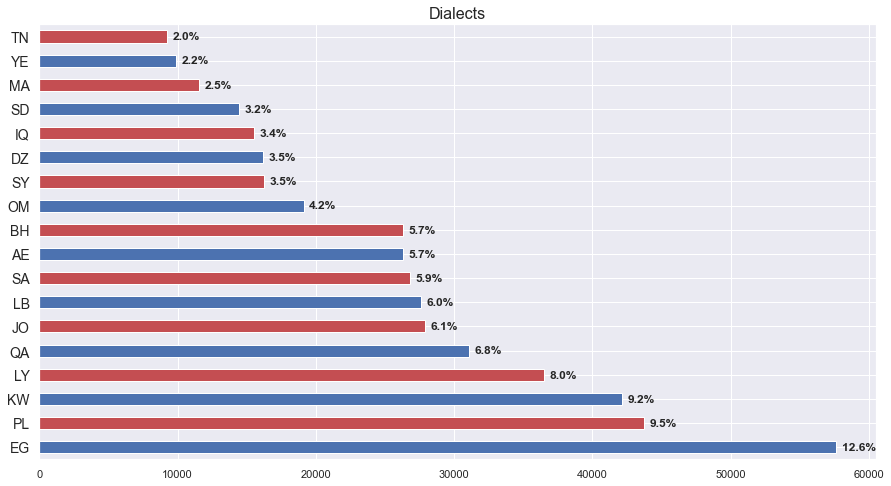

In [10]:
font_size1 = 16
font_size2 = 12

# Setting up figure sizes
rcParams['figure.figsize'] = 15,6
colors=['#4c72b0','#d44e52']

# sb.countplot(df['dialect']);
targets['dialect'].value_counts().plot(kind='barh', figsize=(15,8), color=['b','r']);
plt.title('Dialects', fontsize=font_size1);

plt.yticks(fontsize= font_size2+2);
plt.ylabel('');

Sum = targets['dialect'].value_counts().sum()
for num, value in enumerate(targets['dialect'].value_counts()):
    plt.text(value+400,num,str(np.round(value/Sum*100, decimals = 1))+'%', fontweight='bold',va='center');

---

### Text Pre-processing

In [11]:
file = open("../Data/text_data.txt", "r", encoding='utf-8')
file = json.loads('{'+ file.read().rsplit(",", 1)[0] + '}')

In [12]:
print('Number of Text Cells (Tweets): {}'.format(len(file.keys())))

Number of Text Cells (Tweets): 458197


### Converting the Fetched Text to DataFrame

In [13]:
data_items = file.items()
data_list = list(data_items)

In [14]:
text_df = pd.DataFrame(data_list, columns=["id", "text"])
txt = text_df.copy()

In [15]:
txt.head()

,id,text
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [16]:
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      458197 non-null  object
 1   text    458197 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


In [17]:
txt['text'][0]

'@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .'

In [18]:
sum(txt['id'].duplicated())

0

In [ ]:
def clean_text(text):
    """
    This function is made to clean the tweets using regex or regular expressions,
    it removes:
        - stop_words:   Arabic stop words
        - stop_wow:     Arabic stop words
        - stop_extra:   Arabic stop words
        - mentions:     @arabic_dialect_identifiecation
        - hashtags:     #arabic_dialect_identifiecation
        - underscores:  ______arabic_dialect_identifiecation_____
        - urls:         www.arabicdialectidentifiecation.com
        - numbers:      923
        - laughs :      ههههههه
        - extra_noise : Emotions & Puncituations
    """
    # Noise we want to remove 
    stop_words = ' | '.join(stopwords.words('arabic'))
    stop_wow = ' | و'.join(stopwords.words('arabic'))
    stop_extra = ' | '.join(['_','٠٠','فيه','وفي','الى','لمن','فقط','على','انا','لان','وانا','يا','الی','الي','اللي','اللى','ヽ'])
    mentions = '(@[A-Za-z0-9]+)'
    hashtags = '(#[A-Za-z0-9_]+)'
    underscores = '(_[_\w_]+)'
    urls = '(\w+:\/\/\S+)'
    numbers = '([0-9]+)'
    extra_noise = '(\s*[A-Za-z]+\b)|([^\w])'
    laughs = '(ه[ه^ه])'
    
    
    # Removing Process
    text = ' '.join(re.sub(stop_words," ",text).split())
    text = ' '.join(re.sub(stop_wow," ",text).split())
    text = ' '.join(re.sub(stop_extra," ",text).split())
    text = ' '.join(re.sub(laughs," ",text).split())
    text = ' '.join(re.sub(urls," ",text).split())
    text = ' '.join(re.sub(mentions," ",text).split())
    text = ' '.join(re.sub(hashtags," ",text).split())
    text = ' '.join(re.sub(numbers," ",text).split())
    text = ' '.join(re.sub(underscores," ",text).split())
    text = ' '.join(re.sub(extra_noise," ",text).split())

    return text

### Printing Cleaned Example

In [ ]:
print('Before Cleaning: {}\nAfter Cleaning: {}'.format(text_df['text'][22], Clean(txt['text'][22])))

Before Cleaning: @ha___m___ed لان الماضي دائماً فيه ريحة خيانه😂
After Cleaning: لان الماضي دائما ريحة خيانه


In [ ]:
print('Before Cleaning: {}\n\nAfter Cleaning: {}'.format(text_df['text'][4594], Clean(txt['text'][4594])))

Before Cleaning: سنة وانا انتظر
طال إنتظاري والوكت محسوب
وانا ادري العمر
يا عمري ساري يا صبر الگلوب
وانا عمري حسابه.. حسابه لما اشوفك
يا زين الدنيا وعيوني تحوفك

#مرني https://t.co/HekL210nOv

After Cleaning: سنة وانا انتظر طال إنتظاري والوكت محسوب وانا ادري العمر يا عمري ساري يا صبر الگلوب وانا عمري حسابه حسابه لما اشوفك يا زين الدنيا وعيوني تحوفك مرني


### Apply Filter to the Dataset

In [ ]:
txt['text'] = txt['text'].apply(lambda text: Clean(text))

### Printing an Example after Cleaning

In [ ]:
print('Example 1: {}\nExample 2: {}'.format(txt['text'][0], txt['text'][8]))

Example 1: لكن بالنهاية ينتفض يغير
Example 2: يمكن سؤال فات الكثير اللي يصور شنو موقفه وكأنه يوثق بطوله المفروض حتى المصور يحال للقضاء لان نظرات الطفله تستنجد باتجاه الكاميرا


---

### Merging both DataFrames

In [ ]:
txt['id'] = txt['id'].astype('int64')

In [ ]:
df = pd.merge(targets, txt, on='id')

In [ ]:
df.head()

,id,dialect,text
0,962645561252904960,MA,الشيخ ماهر المعيقلي وسعد الغامدي
1,947438652761804800,DZ,البنت تركية مافاهمة عليكي مش زي فانزك كلو عربي
2,799985073168617472,BH,اللهم إرزقنا حظ الدنيا
3,1170952919820177408,LB,اكيد من حقك حبيت ماحبيت الشي بيرجع الك بس كمان...
4,1152726364891561984,EG,لا شوف الفيديو تانى كان متعمد و بيستهبل


In [ ]:
df.info()

---

### Grouping Dialects

<img src='../Images/Geographical distribution of Arabic dialects.PNG'>

In [4]:
df['dialect'].unique()

array(['EG', 'PL', 'JO', 'LY', 'BH', 'QA', 'IQ', 'SA', 'OM', 'SD', 'SY',
       'LB', 'AE', 'KW', 'DZ', 'YE', 'TN', 'MA'], dtype=object)

### Grouping by Geographical location

In [5]:
Sham = ['PL', 'JO', 'SY', 'LB']
Maghreb = ['DZ', 'LY', 'TN', 'MA']
Gulf = ['BH', 'QA', 'IQ', 'SA', 'OM', 'AE', 'KW','YE']

### Defining Grouping Function

In [6]:
def change_dialect(dialect):

    Gulf_dialects = ['BH', 'QA', 'IQ', 'SA', 'OM', 'AE', 'KW','YE']
    Maghreb_dialects = ['DZ', 'LY', 'TN', 'MA']
    Sham_dialects = ['PL', 'JO', 'SY', 'LB']
    
    
    Gulf = ' | '.join(Gulf_dialects)
    Maghreb = ' | '.join(Maghreb_dialects)
    Sham = ' | '.join(Sham_dialects)
    
    # Removing Process
    if dialect in Gulf_dialects:
        dialect = ''.join(re.sub(Gulf," ","GULF").split())
    
    elif dialect in Maghreb_dialects:
        dialect = ''.join(re.sub(Maghreb," ","MAGHREB").split())
    
    elif dialect in Sham_dialects:
        dialect = ''.join(re.sub(Sham," ","SHAM").split())
        
    elif dialect == 'EG':
        dialect = 'EGYPT'
        
    elif dialect == 'SD':
        dialect = 'SODAN'

    return dialect

In [7]:
df['dialect'] = df['dialect'].apply(lambda dialect: change_dialect(dialect))

In [8]:
df.head()

,id,dialect,text
0,934055133171912832,EGYPT,سؤال يفهم بتوتر الناس بالكوارث بيدوروا علي هشت...
1,1171407436814721024,SHAM,هادا الصحن تخصصه حمص فول حاطين لبنة
2,1054942138985791616,SHAM,رايحه اداوم بدون نوم الخير
3,863396710063722496,MAGHREB,انا السبعة الصبح للواحد الظهر
4,721682683580039168,GULF,الخبر الصحيح وجه الدقة شوهد حامل سماعات موكب ع...


In [9]:
df['dialect'].unique()

array(['EGYPT', 'SHAM', 'MAGHREB', 'GULF', 'SODAN'], dtype=object)

### Visualizing Grouped Dialects

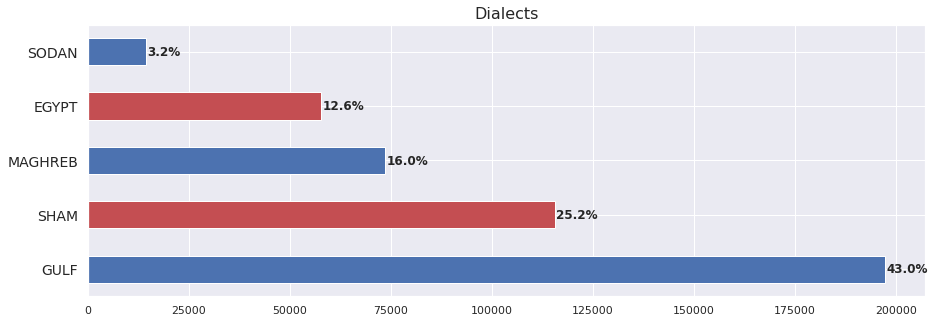

In [10]:
font_size1 = 16
font_size2 = 12

# Setting up figure sizes
rcParams['figure.figsize'] = 15,5
colors=['#4c72b0','#d44e52']

# sb.countplot(df['dialect']);
df['dialect'].value_counts().plot(kind='barh', figsize=(15,5), color=['b','r']);
plt.title('Dialects', fontsize=font_size1);

plt.yticks(fontsize= font_size2+2);
plt.ylabel('');

Sum = df['dialect'].value_counts().sum()
for num, value in enumerate(df['dialect'].value_counts()):
    plt.text(value+400,num,str(np.round(value/Sum*100, decimals = 1))+'%', fontweight='bold',va='center');

### Saving The Cleaned Dataset

In [11]:
df.to_csv('/content/drive/MyDrive/Colab/Arabic Dialect Classifier/5_class_dialects.csv', index = False)

---

### Converting the words into Numbers (Counts, Ratios, Logs) & Noise Reduction

### Count of each Term

In [12]:
def count_words(dialect):
    
    global total_words_count
    dialect_words = Counter()
    dialect_df = df[df['dialect'] == dialect]

    for num, text in enumerate(df['text']):
        if df['dialect'][num] == dialect:
            for word in text.split(" "):
                dialect_words[word] += 1
                total_words_counts[word] += 1
                    
    return dialect_words, total_words_counts

### Calculate the Ratio (Weight) of each Term for each Dialect

In [13]:
def calculate_ratio(dialect_words):
    global total_words_counts
    global margin
    
    dialect_ratios = Counter()

    for term, count in list(total_words_counts.most_common()):
        ratio = dialect_words[term] / total_words_counts[term]+1 # Avoiding Zero Division
        dialect_ratios[term] = ratio
    return dialect_ratios

### Calculate the Log of each Ratio & Applying Cut-off Margin

In [14]:
def log_of_ratios(ratios_of_dialect_words):
    
    global ratio_margin
    dialect_logs = Counter()
    
    for term, ratio in list(ratios_of_dialect_words.most_common()):
        if ratio > ratio_margin:
            dialect_logs[term] = np.log(ratio)
    return dialect_logs

### Calculating Counts

In [15]:
total_words_counts = Counter()
count_of_dialect_words = Counter()

for dialect in df['dialect'].unique():
    count_of_dialect_words[dialect], total_words_count = count_words(dialect)

In [16]:
total_words_counts.most_common(10)

[('الله', 49707),
 ('مش', 31120),
 ('والله', 24778),
 ('شي', 19784),
 ('ما', 17275),
 ('انت', 16834),
 ('ان', 16260),
 ('عشان', 13396),
 ('يعني', 13297),
 ('الناس', 13255)]

In [17]:
list(reversed(total_words_counts.most_common()))[0:10]

[('ماتغسلي', 1),
 ('الماديرنها', 1),
 ('الجعانين', 1),
 ('الامنجين', 1),
 ('حيعتقولنا', 1),
 ('ممارساتك', 1),
 ('تتزوجى', 1),
 ('عشقى', 1),
 ('ولاحوش', 1),
 ('ماصوروها', 1)]

### Calculating Ratios

In [18]:
ratios_of_dialect_words = Counter()

for dialect in df['dialect'].unique():
    ratios_of_dialect_words[dialect] = calculate_ratio(count_of_dialect_words[dialect])

In [19]:
ratios_of_dialect_words["GULF"].most_common(10)

[('البدون', 2.0),
 ('الرويحي', 2.0),
 ('هذيلا', 2.0),
 ('المهلكه', 2.0),
 ('همثون', 2.0),
 ('الغرافه', 2.0),
 ('احين', 2.0),
 ('هذوله', 2.0),
 ('بوخالد', 2.0),
 ('هذيل', 2.0)]

In [20]:
ratios_of_dialect_words["EGYPT"].most_common(10)

[('الأهلى', 2.0),
 ('الهلي', 2.0),
 ('اوووى', 2.0),
 ('هتلاقى', 2.0),
 ('الزملكاويه', 2.0),
 ('معاكوا', 2.0),
 ('الموبيل', 2.0),
 ('مورتا', 2.0),
 ('السبوبة', 2.0),
 ('هبقي', 2.0)]

In [21]:
ratios_of_dialect_words["SHAM"].most_common(10)

[('ياااحرية', 2.0),
 ('هلقيت', 2.0),
 ('بغزة', 2.0),
 ('هيني', 2.0),
 ('هلقد', 2.0),
 ('بديش', 2.0),
 ('هلاء', 2.0),
 ('انداري', 2.0),
 ('يااحرية', 2.0),
 ('وفش', 2.0)]

In [22]:
ratios_of_dialect_words["MAGHREB"].most_common(10)

[('علاش', 2.0),
 ('هلبا', 2.0),
 ('هوما', 2.0),
 ('هضا', 2.0),
 ('دابا', 2.0),
 ('راهم', 2.0),
 ('كيفاش', 2.0),
 ('هادشي', 2.0),
 ('قداش', 2.0),
 ('ihabamir', 2.0)]

### Calculating Logs

In [23]:
ratio_margin = 1
logs_of_dialect_words = Counter()

for dialect in df['dialect'].unique():
    logs_of_dialect_words[dialect] = log_of_ratios(ratios_of_dialect_words[dialect])

In [24]:
logs_of_dialect_words['GULF'].most_common(10)

[('البدون', 0.6931471805599453),
 ('الرويحي', 0.6931471805599453),
 ('هذيلا', 0.6931471805599453),
 ('المهلكه', 0.6931471805599453),
 ('همثون', 0.6931471805599453),
 ('الغرافه', 0.6931471805599453),
 ('احين', 0.6931471805599453),
 ('هذوله', 0.6931471805599453),
 ('بوخالد', 0.6931471805599453),
 ('هذيل', 0.6931471805599453)]

In [25]:
logs_of_dialect_words['EGYPT'].most_common(10)

[('الأهلى', 0.6931471805599453),
 ('الهلي', 0.6931471805599453),
 ('اوووى', 0.6931471805599453),
 ('هتلاقى', 0.6931471805599453),
 ('الزملكاويه', 0.6931471805599453),
 ('معاكوا', 0.6931471805599453),
 ('الموبيل', 0.6931471805599453),
 ('مورتا', 0.6931471805599453),
 ('السبوبة', 0.6931471805599453),
 ('هبقي', 0.6931471805599453)]

In [26]:
logs_of_dialect_words['SHAM'].most_common(10)

[('ياااحرية', 0.6931471805599453),
 ('هلقيت', 0.6931471805599453),
 ('بغزة', 0.6931471805599453),
 ('هيني', 0.6931471805599453),
 ('هلقد', 0.6931471805599453),
 ('بديش', 0.6931471805599453),
 ('هلاء', 0.6931471805599453),
 ('انداري', 0.6931471805599453),
 ('يااحرية', 0.6931471805599453),
 ('وفش', 0.6931471805599453)]

In [27]:
logs_of_dialect_words['MAGHREB'].most_common(10)

[('علاش', 0.6931471805599453),
 ('هلبا', 0.6931471805599453),
 ('هوما', 0.6931471805599453),
 ('هضا', 0.6931471805599453),
 ('دابا', 0.6931471805599453),
 ('راهم', 0.6931471805599453),
 ('كيفاش', 0.6931471805599453),
 ('هادشي', 0.6931471805599453),
 ('قداش', 0.6931471805599453),
 ('ihabamir', 0.6931471805599453)]

In [28]:
logs_of_dialect_words['SODAN'].most_common(10)

[('ليهو', 0.6931471805599453),
 ('هسي', 0.6931471805599453),
 ('الكيزان', 0.6931471805599453),
 ('قحت', 0.6931471805599453),
 ('عليهو', 0.6931471805599453),
 ('لحدي', 0.6931471805599453),
 ('معاهو', 0.6931471805599453),
 ('امدرمان', 0.6931471805599453),
 ('ياتو', 0.6931471805599453),
 ('حمدوك', 0.6931471805599453)]

----

### Further Noise Reduction

#### Visualizing the Ratios

In [29]:
for dialect in df['dialect'].unique():
    hist, edges = np.histogram(list(map(lambda x:x[1], reversed(ratios_of_dialect_words[dialect].most_common()))), 
                              density=True, bins=100,normed=True)

    p = figure(tools='pan,wheel_zoom,reset,save', 
               toolbar_location='above',
               title = dialect+' Terms Ratios Affinity Distribution')

    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='#555555')
    show(p)

>**According to the above gaphs we can see that the most noise ratio lies between 1 and 1.2. Let's explore some...**

In [30]:
list(reversed(ratios_of_dialect_words['EGYPT'].most_common()))[0:10]

[('ماتغسلي', 1.0),
 ('الماديرنها', 1.0),
 ('الجعانين', 1.0),
 ('الامنجين', 1.0),
 ('حيعتقولنا', 1.0),
 ('ممارساتك', 1.0),
 ('تتزوجى', 1.0),
 ('عشقى', 1.0),
 ('ولاحوش', 1.0),
 ('ماصوروها', 1.0)]

In [31]:
list(reversed(ratios_of_dialect_words['GULF'].most_common()))[0:10]

[('ماتغسلي', 1.0),
 ('الماديرنها', 1.0),
 ('الجعانين', 1.0),
 ('الامنجين', 1.0),
 ('حيعتقولنا', 1.0),
 ('ممارساتك', 1.0),
 ('تتزوجى', 1.0),
 ('عشقى', 1.0),
 ('ولاحوش', 1.0),
 ('ماصوروها', 1.0)]

In [32]:
list(reversed(ratios_of_dialect_words['SHAM'].most_common()))[0:10]

[('ماتغسلي', 1.0),
 ('الماديرنها', 1.0),
 ('الجعانين', 1.0),
 ('الامنجين', 1.0),
 ('حيعتقولنا', 1.0),
 ('ممارساتك', 1.0),
 ('تتزوجى', 1.0),
 ('عشقى', 1.0),
 ('ولاحوش', 1.0),
 ('ماصوروها', 1.0)]

In [33]:
list(reversed(ratios_of_dialect_words['MAGHREB'].most_common()))[0:10]

[('ماتغسلي', 1.0),
 ('الماديرنها', 1.0),
 ('الجعانين', 1.0),
 ('الامنجين', 1.0),
 ('حيعتقولنا', 1.0),
 ('ممارساتك', 1.0),
 ('تتزوجى', 1.0),
 ('عشقى', 1.0),
 ('ولاحوش', 1.0),
 ('ماصوروها', 1.0)]

In [34]:
len(ratios_of_dialect_words['EGYPT']), len(ratios_of_dialect_words['GULF'])

(505485, 505485)

>Here we can find that there are alot of terms that are not related to the ```EG``` or **Egyptian Dialect**. So we will apply a cutoff margin to the terms that have ratio less than 1.2 or we can apply a little bit higher.

### Applying Cut-off Margin

In [35]:
ratio_margin = 1.3
logs_of_dialect_words = Counter()

for dialect in df['dialect'].unique():
    logs_of_dialect_words[dialect] = log_of_ratios(ratios_of_dialect_words[dialect])

In [36]:
list(reversed(logs_of_dialect_words['EGYPT'].most_common()))[0:10]

[('قدامه', 0.262866903332057),
 ('آه', 0.26290204345329393),
 ('قفل', 0.2634174504521496),
 ('إنهم', 0.2634174504521496),
 ('مصلحته', 0.26358452087272044),
 ('جنبها', 0.26358452087272044),
 ('الفرقة', 0.2638145910451375),
 ('ورئيس', 0.2638145910451375),
 ('طيبة', 0.2638145910451375),
 ('أحداث', 0.2641515750415869)]

In [37]:
list(reversed(logs_of_dialect_words['GULF'].most_common()))[0:10]

[('ميديا', 0.2625340581685527),
 ('النت', 0.2627310799023066),
 ('خليه', 0.2627627502268983),
 ('غبية', 0.26283607386525015),
 ('أسوأ', 0.26290204345329393),
 ('فلو', 0.2629424662760252),
 ('كمية', 0.2629424662760252),
 ('الانستا', 0.2631108117212755),
 ('تعليقات', 0.2631910524434851),
 ('الحدث', 0.2631910524434851)]

In [38]:
list(reversed(logs_of_dialect_words['SHAM'].most_common()))[0:10]

[('بكل', 0.2626117517850293),
 ('هات', 0.26261810378856465),
 ('موقف', 0.26263132282132834),
 ('تفسير', 0.2628088077066412),
 ('الحب', 0.2628088077066412),
 ('عطر', 0.26290204345329393),
 ('بالملعب', 0.2629894598614094),
 ('بكلمة', 0.26304476806639576),
 ('شربت', 0.2631108117212755),
 ('يشوفو', 0.2631910524434851)]

In [39]:
list(reversed(logs_of_dialect_words['MAGHREB'].most_common()))[0:10]

[('يحميك', 0.2626567048848406),
 ('بديت', 0.2626682620378517),
 ('معاها', 0.26269914196127186),
 ('المجرم', 0.2631108117212755),
 ('يسهل', 0.263238008516088),
 ('حبيبة', 0.26329061932762177),
 ('فرحنا', 0.2634174504521496),
 ('عصام', 0.2634174504521496),
 ('عصابة', 0.2634174504521496),
 ('مفروض', 0.26356860022124695)]

In [40]:
len(logs_of_dialect_words['EGYPT']), len(logs_of_dialect_words['GULF']), len(logs_of_dialect_words['SHAM']), len(logs_of_dialect_words['MAGHREB']), len(logs_of_dialect_words['SODAN'])

(76487, 258178, 127646, 96822, 20936)

>We can see now that the terms are more related to the dialect.

### Visualizing the Logs

In [41]:
for dialect in df['dialect'].unique():
    hist, edges = np.histogram(list(map(lambda x:x[1], reversed(logs_of_dialect_words[dialect].most_common()))), 
                              density=True, bins=100,normed=True)

    p = figure(tools='pan,wheel_zoom,reset,save', 
               toolbar_location='above',
               title = dialect+' Terms Ratios Affinity Distribution')

    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='#555555')
    show(p)

In [42]:
terms_in_ratio = set()
for dialect in df['dialect'].unique():
    for term in ratios_of_dialect_words[dialect].keys():
        terms_in_ratio.add(term)
        
terms_in_ratio = list(terms_in_ratio)

In [43]:
len(terms_in_ratio)

505485

In [44]:
high_weight_terms = set()
for dialect in df['dialect'].unique():
    for term in logs_of_dialect_words[dialect].keys():
        high_weight_terms.add(term)
        
high_weight_terms = list(high_weight_terms)

In [45]:
len(high_weight_terms)

503711

>We can see that before using we had 503490 unique terms but now 422793 unique terms. And now we removed the Arabic stop words that we could not remove before.

---